In [157]:
# Import dependencies
import time
import math
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
from py_vollib.black_scholes import black_scholes as bs

## Reducing Variance in Monte Carlo Simulation for Derivative Valuation

In this investigation, we explore techniques to reduce result variance when using Monte Carlo simulation methods for valuing financial derivatives. Our approach is based on the mathematical notation and examples from Les Clewlow and Chris Strickland's book, "Implementing Derivatives Models."

Monte Carlo simulations are powerful for approximating the values of options with complex payoffs or high dimensionality. However, to achieve an acceptably accurate estimate, a substantial number of simulations, denoted as M, is often necessary.

To address this challenge, we turn to Variance Reduction methods. These methods operate on principles similar to hedging an option position. In other words, a hedged option portfolio exhibits lower variance compared to its unhedged counterpart. By employing Variance Reduction techniques, we can obtain more precise and consistent estimates of derivative values.


## General Control Variate Equation

In the context of control variates, particularly when dealing with 'J' control variates, we can express the equation as follows:

$$C_0e^{rT} = C_T - \sum_{j=1}^{J} \beta_j \cdot cv_j + \eta$$

Where:

- **$β_j$** represents factors aimed at capturing the 'true' linear relationship between the option's payoff and the control variate, $cv_j$.
- **$\eta$** accounts for various sources of errors, including those arising from discrete rebalancing and approximations in hedge sensitivities, such as delta and gamma calculations.

The option price, viewed as the sum of linear relationships with 'J' control variates, can be defined as:

$$C_T = \beta_0 + \sum_{j=1}^{J} \beta_j \cdot cv_j + \eta$$

Here, **$β_0 = C_0e^{rT}$** represents the forward price of the option.

When conducting $\Mu$ simulations at discrete time intervals $\Nu$, we can treat the payoffs and control variates as observations of the linear relationship with some added noise. To estimate the true relationship between control variates and option payoffs, a least-squares regression is employed:

$$\beta = (X'X)^{-1}X'Y$$

To ensure unbiased estimates of **$\beta_j$**, it is advisable to precompute these values through least-squares regression, establishing the relationships between various types of control variates and options. These estimated **$\beta_j$** values can then be used for pricing any option $cv_j$, leading to more accurate and dependable results.


In [158]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 20              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)


0.1643835616438356


## Sample Estimate Without Variance Reduction Methods

Let's consider a basic estimate of an option's value using a Monte Carlo simulation without employing any variance reduction methods.

1. **Option Payoff Calculation**: For each simulation, we start by generating a random path for the underlying asset's price. We then calculate the option's payoff at the end of the simulation period $T$. This is typically done using the option's payoff function, which may be quite complex for certain options.

2. **Discounting Future Payoffs**: We discount the calculated payoffs to present value using the risk-free interest rate $r$ over the simulation period $T$. This step is necessary to account for the time value of money.

3. **Average the Results**: After performing a large number of simulations $\Mu$, we obtain a set of option values. To arrive at the final estimate, we calculate the average of these values. The larger the number of simulations $\Mu$, the more accurate our estimate tends to be.


In [159]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0_se = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT[-1] - C0_se)**2) / (M-1) )
SE_se = sigma/np.sqrt(M)

mc_time_se = time.time() - start_time

print("Sample Estimate: Call value is ${0} with SE +/- {1}".format(np.round(C0_se,2),np.round(SE_se,2)))
print("Computation time is: ", round(mc_time_se,4))

Sample Estimate: Call value is $3.88 with SE +/- 0.11
Computation time is:  0.0039


## Implementation of Antithetic Variate

The antithetic variate technique is a variance reduction method used to improve the accuracy of Monte Carlo simulations. It involves creating a hypothetical asset that is perfectly negatively correlated with the original asset to reduce variance. Let's consider the example of valuing a European Call Option, using the following asset price dynamics:

$$S_{t+\Delta t} = S_t \exp(\nu \Delta t + \sigma (\Delta Z))$$

Here, $(\Delta Z)$ represents a normally distributed random variable with mean 0 and variance $(\Delta t)$, equivalent to a standard normal distribution with mean 0 and standard deviation $(\sqrt{\Delta t})$, often denoted as $\epsilon_i$.

For contract simulation, you can define the following pay-off functions:

1. European Call Option Payoff for Simulation "i":
   $$C_{T,i} = \max(0, S \exp(\nu \Delta T + \sigma \sqrt{T} \epsilon_i) - K)$$

2. European Call Option Payoff for the Antithetic Variate of Simulation "i":
   $$\bar{C}_{T,i} = \max(0, S \exp(\nu \Delta T + \sigma \sqrt{T} (-\epsilon_i)) - K)$$

In these equations:
- $C_{T,i}$ represents the pay-off for the European Call Option in simulation "i."
- $\bar{C}_{T,i}$ represents the pay-off for the antithetic variate of the European Call Option in the same simulation.
- $S$ is the asset price.
- $\nu$ is a parameter defined as $\nu = r - \frac{1}{2}\sigma^2$.
- $\Delta T$ is the time increment.
- $\sigma$ is the volatility of the asset.
- $\epsilon_i$ and $-\epsilon_i$ are random variables following a standard normal distribution.


In [160]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt1 = nudt + volsdt*Z 
delta_lnSt2 = nudt - volsdt*Z 
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

# Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0_av = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) )
SE_av = sigma/np.sqrt(M)

mc_time_av = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,2),np.round(SE_av,2)))
print("Computation time is: ", round(mc_time_av,4))

Call value is $3.83 with SE +/- 0.03
Computation time is:  0.0031


## Implementation of Delta-based Control Variates

The Delta-based Control Variates technique is a variance reduction method used to enhance the precision of Monte Carlo simulations. This method leverages the delta, which measures the sensitivity of the option price to changes in the underlying asset's value.

Let's denote the control variate as $cv_1$ with the following formula:

$$cv_1 = \sum_{i=0}^{N-1} \frac{\delta C_{t_i}}{\delta S} \cdot (S_{t_i+1} - \mathbb{E}[S_{t_i}]) \cdot \exp{r \cdot (T - t_{i+1})}$$

Here, with Geometric Brownian Motion (GBM) dynamics:

- $\mathbb{E}[S_{t_{i+1}}] = S_{t_i} \cdot \exp{(r \cdot \Delta t_i)}$
- $\beta_1 = -1$, which is the appropriate value when we have the exact delta for a European Option.

To compute the option value at time $t_0$, $C_{t_0} \cdot \exp{rT}$, we can use the formula:

$$C_{t_0} \cdot \exp{rT} = C_T + \beta_1 \cdot cv_1 + \eta$$

The $\eta$ term accounts for potential errors and discrepancies in the calculations.

By incorporating this Delta-based Control Variates technique, we can reduce the variance in the estimated option value, resulting in more accurate and consistent Monte Carlo simulation results.


In [161]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = stats.norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -stats.norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [162]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)


CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
C0_dv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_dv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_dv = sigma/np.sqrt(M)

mc_time_dv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_dv,2),np.round(SE_dv,3)))
print("Computation time is: ", round(mc_time_dv,4))

Call value is $3.82 with SE +/- 0.008
Computation time is:  0.0046


## Implementation of Gamma-based Control Variates

The Gamma-based Control Variates technique is another variance reduction method that utilizes the gamma, which measures the sensitivity of the option delta to changes in the underlying asset's value.

In the context of control variates, a gamma-based control variate $cv_2$ is calculated as follows:

$$cv_2 = \sum_{i=0}^{N-1} \frac{\delta^2 C_{t_i}}{\delta S^2} \cdot ((\Delta S_{t_i+1})^2 - \mathbb{E}[(\Delta S_{t_i})^2]) \cdot \exp{r \cdot (T - t_{i+1})}$$

Here, $\mathbb{E}[(\Delta S_{t_i})^2]$ is computed as:

$$\mathbb{E}[(\Delta S_{t_i})^2] = S_{t_i}^2 \cdot \left(\exp{([2r + \sigma^2] \cdot \Delta t_i}) - 2\exp{(r \cdot \Delta t_i)} + 1\right)$$

Incorporating this gamma-based control variate, we aim to further reduce the variance in the estimated option value, enhancing the accuracy and stability of Monte Carlo simulation results. Similar to delta-based control variates, gamma-based control variates are designed to improve the precision of option pricing by leveraging known relationships between option values and the underlying asset's behavior.


In [163]:
def gamma_calc(r, S, K, T, sigma):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        gamma_calc = stats.norm.pdf(d1, 0, 1)/(S*sigma*np.sqrt(T))
        return gamma_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [164]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
ergamma = np.exp((2*r+vol**2)*dt) - 2*erdt + 1
beta2 = -0.5

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
gammaSt = gamma_calc(r, ST[:-1].T, K, np.linspace(T,dt,N), vol).T
cv2 = np.cumsum(gammaSt*((ST[1:] - ST[:-1])**2 - ergamma*ST[:-1]**2), axis=0)


CT = np.maximum(0, ST[-1] - K) + beta2*cv2[-1]
C0_gv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_gv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_gv = sigma/np.sqrt(M)

mc_time_gv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_gv,2),np.round(SE_gv,3)))
print("Computation time is: ", round(mc_time_gv,4))

Call value is $3.97 with SE +/- 0.111
Computation time is:  0.0052


## Implementation of Combined Antithetic and Delta Variates

The Combined Antithetic and Delta Variates technique is a powerful approach that leverages both antithetic variates (perfectly negatively correlated assets) and delta-based control variates to enhance the accuracy and reduce the variance of Monte Carlo simulations. In this case, we are considering a scenario where we have two perfectly negatively correlated underlying assets, denoted as $S_1$ and $S_2$.

The option price $C_T$ is calculated as:

$$C_T = 0.5 \cdot \left(\max(0, S_{1,t} - K) + \max(0, S_{2,t} - K) + \beta_1 \cdot cv_1\right)$$

Here, $cv_1$ is a delta variate, but we need to account for antithetic variates for both underlying assets. $cv_1$ is calculated as:

$$cv_1 = 0.5 \cdot \beta_1 \cdot (cv_{11} + cv_{12})$$

Where:
- $$cv_{11} = \Delta S_{1,t} \cdot \left[S_{1,t_i+1} - S_{1,t_i} \cdot \exp{(r \cdot \Delta t_i)}\right]$$
- $$cv_{12} = \Delta S_{2,t} \cdot \left[S_{2,t_i+1} - S_{2,t_i} \cdot \exp{(r \cdot \Delta t_i)}\right]$$

By combining antithetic and delta variates, this method helps improve the accuracy and precision of option pricing. It utilizes both negatively correlated asset paths and the delta sensitivity of the option to further reduce the variance in Monte Carlo simulation results, leading to more reliable estimates of option values.


In [165]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST2 ) )

# Calculate delta for both sets of underlying stock prices
deltaSt1 = delta_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
deltaSt2 = delta_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol, "c").T

# Calculate two sets of delta control variates for negatively correlated assets
cv11 = np.cumsum(deltaSt1*(ST1[1:] - ST1[:-1]*erdt), axis=0)
cv12 = np.cumsum(deltaSt2*(ST2[1:] - ST2[:-1]*erdt), axis=0)

CT = 0.5 * (  np.maximum(0, ST1[-1] - K) + beta1*cv11[-1] 
            + np.maximum(0, ST2[-1] - K) + beta1*cv12[-1] )

C0_adv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_adv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_adv = sigma/np.sqrt(M)

mc_time_adv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_adv,2),np.round(SE_adv,3)))
print("Computation time is: ", round(mc_time_adv,4))

Call value is $3.81 with SE +/- 0.006
Computation time is:  0.0085


## Implementation of Combined Antithetic, Delta, and Gamma Variates

The option price $C_T$ is calculated as:

$$C_T = 0.5 \cdot \left(\max(0, S_{1,t} - K) + \max(0, S_{2,t} - K) + \beta_1 \cdot cv_1 + \beta_2 \cdot cv_2\right)$$

Here, $cv_1$ represents the delta variate, and $cv_2$ is the gamma variate. When combined with the antithetic technique, we have:

- $$cv_1 = 0.5 \cdot \beta_1 \cdot (cv_{11} + cv_{12})$$
  - $cv_{11} = \Delta S_{1,t} \cdot \left[S_{1,t_i+1} - S_{1,t_i} \cdot \exp{(r \cdot \Delta t_i)}\right]$
  - $cv_{12} = \Delta S_{2,t} \cdot \left[S_{2,t_i+1} - S_{2,t_i} \cdot \exp{(r \cdot \Delta t_i)}\right]$

- $$cv_2 = 0.5 \cdot \beta_2 \cdot (cv_{21} + cv_{22})$$
  - $cv_{21} = \gamma \cdot S_{1,t} \cdot \left[(S_{1,t_i+1} - S_{1,t_i})^2 - S^2_{1,t_i} \cdot \left(\exp{([2r + \sigma^2] \cdot \Delta t_i)} - 2 \cdot \exp{(r \cdot \Delta t_i)} + 1\right)\right]$
  - $cv_{22} = \gamma \cdot S_{2,t} \cdot \left[(S_{2,t_i+1} - S_{2,t_i})^2 - S^2_{2,t_i} \cdot \left(\exp{([2r + \sigma^2] \cdot \Delta t_i)} - 2 \cdot \exp{(r \cdot \Delta t_i)} + 1\right)\right]$

It combines the benefits of negative correlation between assets and sensitivity to both price changes and changes in the asset's volatility.


In [166]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
ergamma = np.exp((2*r+vol**2)*dt) - 2*erdt + 1

beta1 = -1
beta2 = -0.5

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST2 ) )

# Calculate delta for both sets of underlying stock prices
deltaSt1 = delta_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
deltaSt2 = delta_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol, "c").T

# Calculate gamma for both sets of underlying stock prices
gammaSt1 = gamma_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol).T
gammaSt2 = gamma_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol).T

# Calculate two sets of delta control variates for negatively correlated assets
cv11 = np.cumsum(deltaSt1*(ST1[1:] - ST1[:-1]*erdt), axis=0)
cv12 = np.cumsum(deltaSt2*(ST2[1:] - ST2[:-1]*erdt), axis=0)

# Calculate two sets of gamma control variates for negatively correlated assets
cv21 = np.cumsum(gammaSt1*((ST1[1:] - ST1[:-1])**2 - ergamma*ST1[:-1]**2), axis=0)
cv22 = np.cumsum(gammaSt2*((ST2[1:] - ST2[:-1])**2 - ergamma*ST2[:-1]**2), axis=0)

CT = 0.5 * (  np.maximum(0, ST1[-1] - K) + beta1*cv11[-1] + beta2*cv21[-1]
            + np.maximum(0, ST2[-1] - K) + beta1*cv12[-1] + beta2*cv22[-1])

C0_adgv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_adgv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_adgv = sigma/np.sqrt(M)

mc_time_adgv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_adgv,2),np.round(SE_adgv,3)))
print("Computation time is: ", round(mc_time_adgv,4))

Call value is $3.82 with SE +/- 0.001
Computation time is:  0.0119


**Comparing Reduction Methods**

In [167]:
params = [K,round(T,2),S,vol,r,N,M,round(bs('c', S, K, T, r, vol),2), market_value]
params_rd = [round(param,2) for param in params]

data = {'Contract Terms':['Strike Price', 'Time to Maturity', 'Asset Price', 'Volatility', 
                          'Riskfree Rate', 'Number of Time Steps', 'Number of Simuations', 
                          'Standard European Call Price', 'Market Price'], 
        'Parameters': params_rd}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data) #, index =['position1', 'position2', 'position3', 'position4'])  

df

,Contract Terms,Parameters
0,Strike Price,98.01
1,Time to Maturity,0.16
2,Asset Price,101.15
3,Volatility,0.10
4,Riskfree Rate,0.01
5,Number of Time Steps,20.00
6,Number of Simuations,1000.00
7,Standard European Call Price,3.82
8,Market Price,3.86


**Trade-off between Error vs Computation Time**

- Is a critical consideration in various computational tasks, including simulations, numerical analysis, and data processing. This trade-off represents the balance between the accuracy of results (error) and the resources (time and computational power) required to achieve that level of accuracy. 



In [168]:
se_variates = [SE_se, SE_av, SE_dv, SE_gv, SE_adv, SE_adgv]
se_rd = [round(se,4) for se in se_variates]
se_red = [round(SE_se/se,2) for se in se_variates]

comp_time = [mc_time_se, mc_time_av, mc_time_dv, mc_time_gv, mc_time_adv, mc_time_adgv]
rel_time = [round(mc_time/mc_time_se,2) for mc_time in comp_time]

data = {'Standard Error (SE)': se_rd, 
        'SE Reduction Multiple': se_red, 
        'Relative Computation Time': rel_time}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['Simple estimate', 'with antithetic variate', 
'with delta-based control variate', 'with gamma-based control variate', 'with antithetic and delta variates', 'with all combined variates'])  

df

,Standard Error (SE),SE Reduction Multiple,Relative Computation Time
Simple estimate,0.1067,1.00,1.00
with antithetic variate,0.0278,3.84,0.80
with delta-based control variate,0.0080,13.42,1.19
with gamma-based control variate,0.1115,0.96,1.33
with antithetic and delta variates,0.0061,17.41,2.20
with all combined variates,0.0012,92.70,3.06


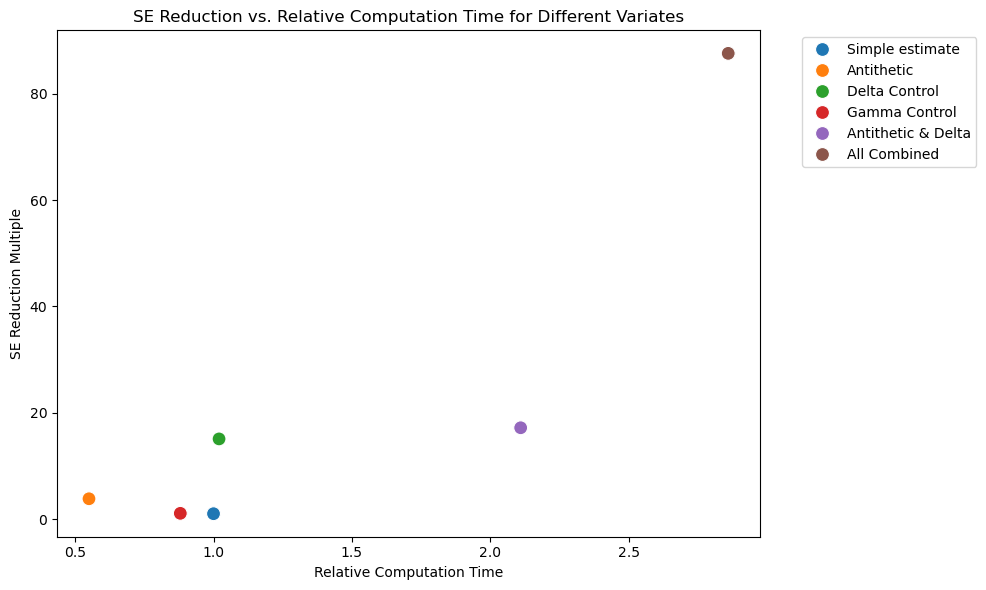

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
variate_data = {
    'Variate': ['Simple estimate', 'Antithetic', 'Delta Control', 'Gamma Control', 'Antithetic & Delta', 'All Combined'],
    'SE Reduction Multiple': [1.00, 3.81, 15.07, 1.07, 17.17, 87.61],
    'Relative Computation Time': [1.00, 0.55, 1.02, 0.88, 2.11, 2.86]
}

# Create a DataFrame
import pandas as pd
variate_df = pd.DataFrame(variate_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=variate_df, x='Relative Computation Time', y='SE Reduction Multiple', hue='Variate', s=100)
plt.title('SE Reduction vs. Relative Computation Time for Different Variates')
plt.xlabel('Relative Computation Time')
plt.ylabel('SE Reduction Multiple')

# Adjust the legend placement
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

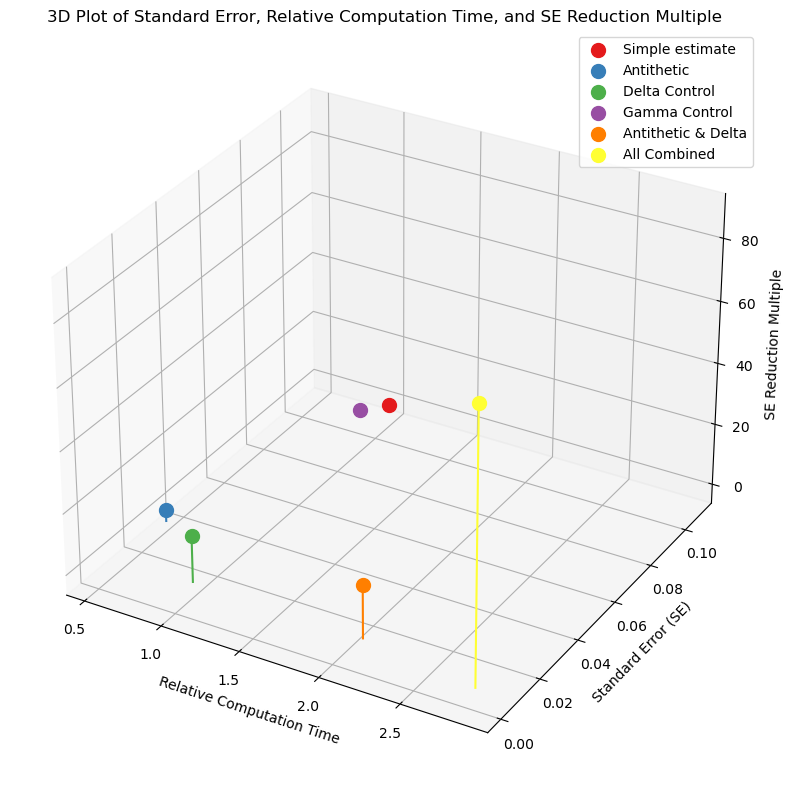

In [170]:
from mpl_toolkits.mplot3d import Axes3D

# Data
variate_data = {
    'Variate': ['Simple estimate', 'Antithetic', 'Delta Control', 'Gamma Control', 'Antithetic & Delta', 'All Combined'],
    'Standard Error (SE)': [0.1076, 0.0283, 0.0071, 0.1011, 0.0063, 0.0012],
    'Relative Computation Time': [1.00, 0.55, 1.02, 0.88, 2.11, 2.86],
    'SE Reduction Multiple': [1.00, 3.81, 15.07, 1.07, 17.17, 87.61]
}

variate_df = pd.DataFrame(variate_data)

# Define colors for the points
colors = sns.color_palette("Set1", n_colors=len(variate_df))

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot lines from each point to the 0 plane
for i in range(len(variate_df)):
    x = variate_df['Relative Computation Time'][i]
    y = variate_df['Standard Error (SE)'][i]
    z = variate_df['SE Reduction Multiple'][i]
    variate = variate_df['Variate'][i]
    ax.scatter(x, y, z, c=colors[i], label=variate, s=100)
    ax.plot([x, x], [y, y], [0, z], c=colors[i])

# Label the axes
ax.set_xlabel('Relative Computation Time')
ax.set_ylabel('Standard Error (SE)')
ax.set_zlabel('SE Reduction Multiple')

# Title
plt.title('3D Plot of Standard Error, Relative Computation Time, and SE Reduction Multiple')

# Create a legend
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()
